In [ ]:
from bs4 import BeautifulSoup
import requests
import time
import csv
from tqdm import tqdm
from textblob import TextBlob
from transformers import pipeline
import spacy
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import re

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Définir les en-têtes HTTP pour éviter d'être bloqué
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'
}

# Fonction pour scraper une page et récupérer tous les articles
def scrape_all_page(url):
    all_articles = []  # Liste de tous les articles
    seen_articles = set()  # Ensemble pour garder trace des articles déjà ajoutés

    try:
        # Envoyer une requête HTTP pour obtenir la page
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Trouver tous les articles dans les balises <div class="thread">
            articles = soup.find_all("div", class_="thread")
            
            for article in articles:
                # Extraire le titre
                title_element = article.find("h3", class_="teaser__title")
                title_text = title_element.get_text(strip=True) if title_element else "Titre non disponible"
                
                # Extraire l'URL de l'article
                link_element = article.find("a", class_="teaser__link")
                article_url = link_element["href"] if link_element else None
                if article_url and not article_url.startswith("http"):
                    article_url = f"https://www.lemonde.fr{article_url}"  # Construire l'URL complète si nécessaire
                
                # Extraire la description
                description_element = article.find("p", class_="teaser__desc")
                description_text = description_element.get_text(strip=True) if description_element else "Description non disponible"
                
                # Ajouter l'article à la liste si non déjà vu
                if article_url and article_url not in seen_articles:
                    all_articles.append([title_text, description_text, article_url])
                    seen_articles.add(article_url)

            return all_articles

        else:
            print(f"Erreur HTTP {response.status_code} lors de l'accès à {url}")
            return []

    except requests.RequestException as e:
        print(f"Erreur de requête pour {url}: {e}")
        return []

# Exemple d'utilisation
url_1 = "https://www.lemonde.fr/agriculture/"
url_2 = "https://www.lemonde.fr/agriculture/2"
articles = scrape_all_page(url_1)
articles += scrape_all_page(url_2)

In [3]:
def extract_date_from_url(url):
    """
    Extrait la date au format YYYY/MM/DD d'une URL de l'article.
    """
    # Expression régulière pour extraire la date au format YYYY/MM/DD
    date_pattern = r'(\d{4})/(\d{2})/(\d{2})'
    match = re.search(date_pattern, url)
    
    if match:
        # Retourner la date au format YYYY-MM-DD
        return f"{match.group(1)}-{match.group(2)}-{match.group(3)}"
    else:
        return None  # Si aucune date n'est trouvée

In [4]:
# Fonction pour extraire les informations d'un article
def fetch_article_details(article_data, headers):
    title, summary, url = article_data
    try:
        # Faire la requête HTTP
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')

            # Extraire le titre
            title_tag = soup.find('h1', class_='article__title')
            title = title_tag.get_text(strip=True) if title_tag else "Titre non trouvé"

            # Extraire la description (résumé) depuis la balise <p class="article__desc">
            summary_tag = soup.find('p', class_='article__desc')
            summary = summary_tag.get_text(strip=True) if summary_tag else "Résumé non trouvé"

            # Extraire la date de publication depuis la section 'meta__date-reading'
            date = extract_date_from_url(url)

            # Extraire uniquement le premier paragraphe à partir de la classe 'article__paragraph'
            first_paragraph_tag = soup.find('p', class_='article__paragraph')
            first_paragraph = first_paragraph_tag.get_text(strip=True) if first_paragraph_tag else "Premier paragraphe non trouvé"

            return {
                "Title": title,
                "Summary": summary,
                "Date": date,
                "First_Paragraph": first_paragraph
            }
        else:
            print(f"Erreur HTTP {response.status_code} pour {url}")
            return None
    except requests.RequestException as e:
        print(f"Erreur de requête pour {url}: {e}")
        return None


In [5]:
# Liste pour stocker les résultats détaillés de chaque article
detailed_articles = []

# Boucle pour appliquer la fonction à chaque article
for article_data in articles:
    article_details = fetch_article_details(article_data, headers)
    
    # Si les détails de l'article ont été extraits avec succès, ajoutez-les à la liste
    if article_details:
        detailed_articles.append(article_details)


In [6]:
# Fonction pour filtrer les articles contenant le mot "bio" et inclure une liste des textes où il a été trouvé
def filter_bio_articles(detailed_articles):
    bio_articles = []
    
    # Parcourir tous les articles de detailed_articles
    for article in detailed_articles:
        # Initialiser une liste pour stocker les textes où "bio" est trouvé
        found_in_texts = []
        
        # Vérifier si le mot "bio" est présent dans le titre
        if "bio" in article['Title'].lower():
            found_in_texts.append(article['Title'])
        
        # Vérifier si le mot "bio" est présent dans la description (résumé)
        if "bio" in article['Summary'].lower():
            found_in_texts.append(article['Summary'])
        
        # Vérifier si le mot "bio" est présent dans le premier paragraphe
        if "bio" in article['First_Paragraph'].lower():
            found_in_texts.append(article['First_Paragraph'])
        
        # Si le mot "bio" est trouvé dans l'un des champs, ajouter l'article à la liste bio_articles
        if found_in_texts:
            article["Found_in"] = found_in_texts  # Ajouter les textes où "bio" a été trouvé sous forme de liste
            bio_articles.append(article)
    
    return bio_articles

# Appliquer la fonction pour filtrer les articles contenant le mot "bio"
bio_filtered_articles = filter_bio_articles(detailed_articles)


In [7]:
# Charger le modèle spaCy pour le français
nlp = spacy.load("fr_core_news_sm")

# Fonction pour filtrer les phrases contenant "bio"
def filter_sentences_containing_bio(article):
    # Extraire la liste de textes de la clé "Found_in"
    filtered_found_in = []
    
    # Parcours de toutes les phrases dans "Found_in"
    for text in article['Found_in']:
        # Traitement du texte avec spaCy pour obtenir un document linguistique
        doc = nlp(text)
        
        # Vérifier si le mot "bio" (ou variantes) est dans le texte
        # En convertissant le texte en minuscules pour la recherche
        if "bio" in text.lower():
            filtered_found_in.append(text)
    
    # Mettre à jour la clé "Found_in" de l'article avec les phrases filtrées
    article['Found_in'] = filtered_found_in
    
    return article

# Appliquer la fonction sur l'exemple d'article
for article in bio_filtered_articles:
    article = filter_sentences_containing_bio(article)

# Afficher les résultats filtrés
print(len(bio_filtered_articles))

16


In [9]:

# Charger explicitement le modèle de sentiment d'Hugging Face
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")

def analyze_sentiment_bio_with_model(text):
    """
    Utilise un modèle open-source pour analyser le sentiment d'un texte concernant le bio.
    Le score sera entre 0 (négatif) et 1 (positif).
    """
    # Utiliser le modèle de sentiment pour prédire le sentiment
    result = sentiment_analyzer(text)

    # Le modèle retourne une liste avec un dictionnaire contenant les labels et scores
    sentiment = result[0]
    
    # Convertir le label en score : 'LABEL_1' est positif, 'LABEL_0' est négatif
    if sentiment['label'] == 'POSITIVE':
        return sentiment['score']
    else:
        return 1 - sentiment['score']  # Retourner un score entre 0 et 1 pour un sentiment négatif


Device set to use cpu


In [10]:
# Fonction pour appliquer l'analyse de sentiment à chaque élément dans la liste de dictionnaires
def add_sentiment_score_to_list_of_dicts(data):
    """
    Applique l'analyse de sentiment sur chaque phrase de la clé 'Found_in' dans une liste de dictionnaires
    et ajoute la moyenne des scores de sentiment à chaque dictionnaire.
    """
    for entry in data:
        # Extraire les phrases de la clé 'Found_in'
        sentences = entry['Found_in']
        
        # Appliquer l'analyse de sentiment à chaque phrase
        sentiment_scores = [analyze_sentiment_bio_with_model(sentence) for sentence in sentences]
        
        # Calculer la moyenne des scores
        average_score = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0
        
        # Ajouter la moyenne au dictionnaire
        entry['Average_Sentiment_Score'] = average_score
    
    return data

# Appliquer la fonction pour ajouter la moyenne des scores de sentiment à chaque dictionnaire
data_with_scores = add_sentiment_score_to_list_of_dicts(bio_filtered_articles)


In [22]:
def plot_sentiment_score_by_date(data):
    """
    Génère un graphique montrant le score de sentiment en fonction de la date de publication.
    
    :param data: Liste de dictionnaires contenant les articles avec les scores de sentiment et les dates.
    """
    # Extraire les dates et les scores de sentiment dans des listes
    dates = []
    sentiment_scores = []
    
    for entry in data:
        date_str = entry['Date']
        try:
            # Essayer de convertir la date au format 'YYYY/MM/DD'
            date_obj = datetime.strptime(date_str, '%Y-%m-%d')
            dates.append(date_obj)
            
            # Ajouter le score de sentiment de l'article
            sentiment_scores.append(entry['Average_Sentiment_Score'])
        
        except ValueError as e:
            print(f"Erreur de format de date pour '{entry['Title']}': {e}")
            continue
    
    # Vérification de la longueur des listes pour éviter les erreurs
    if len(dates) != len(sentiment_scores):
        print("Les longueurs des listes 'dates' et 'sentiment_scores' ne correspondent pas.")
        return

    # Créer un DataFrame pandas pour faciliter le traitement
    df = pd.DataFrame({
        'Date': dates,
        'Sentiment_Score': sentiment_scores
    })

    # Trier les données par date
    df.sort_values('Date', inplace=True)

    # Formater les dates au format 'dd/mm/yy'
    df['Formatted_Date'] = df['Date'].apply(lambda x: x.strftime('%d/%m/%y'))

    # Tracer les données
    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'], df['Sentiment_Score'], marker='o', linestyle='-', color='b', label='Sentiment Score')

    # Ajouter des labels et un titre
    plt.xlabel('Date de Publication')
    plt.ylabel('Score de Sentiment')
    plt.title('Score de Sentiment en Fonction de la Date de Publication')

    # Changer l'affichage des dates sur l'axe des X avec le format 'dd/mm/yy'
    plt.xticks(df['Date'], df['Formatted_Date'], rotation=45)
    
    # Ajouter une grille
    plt.grid(True)

    # Afficher le graphique
    plt.tight_layout()
    plt.show()


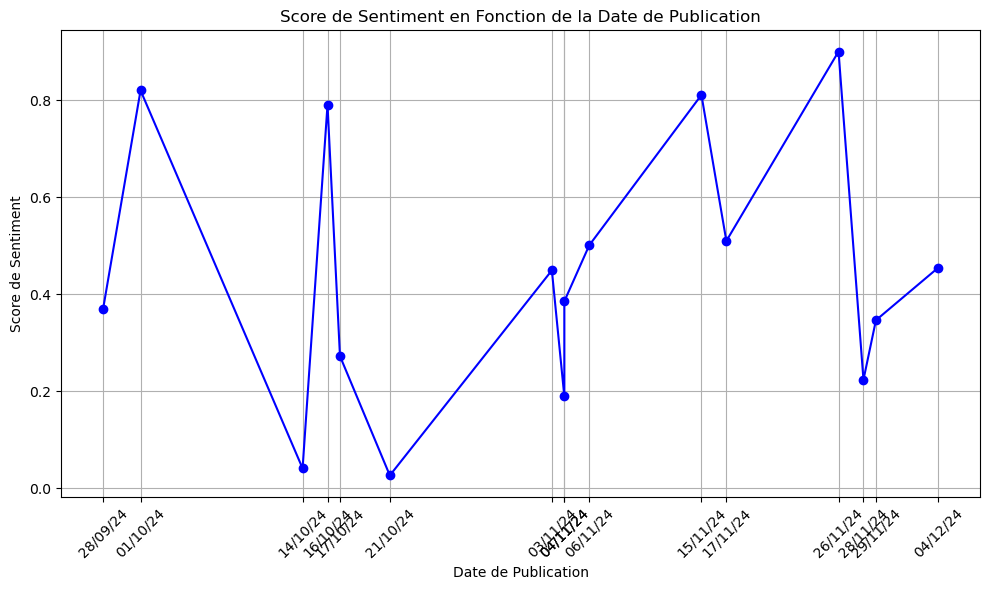

In [23]:
plot_sentiment_score_by_date(bio_filtered_articles)